In [1]:
# 필요한 라이브러리 불러오기
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision", 8)
import pickle

## 데이터 불러오기

In [2]:
# 경로 설정
path_to_train = 'age_related_conditions_dataset/'
path_to_test = 'age_related_conditions_dataset/'
path_to_models = '/age_related_conditions_models/'

In [3]:
# train, greeks 데이터셋 불러오기
train, greeks = pd.read_csv(f'{path_to_train}train.csv'), pd.read_csv(f'{path_to_train}greeks.csv')

## EDA
* 데이터셋 확인
* 결측치 확인
* 데이터 시각화

### 데이터 확인

In [25]:
train.head(3)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.29816194,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.12034286,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.17322900,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.97800000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.70956011,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.19694118,0


In [4]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [6]:
# 결측치 확인
train.isnull().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

### 데이터 시각화

In [8]:
# EJ 컬럼의 수치형으로 변환
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1})

# 컬럼명 변경
train = train.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'})

# train, greeks 데이터 결합
data = pd.concat([train, greeks.set_index('Id')], axis=1)

# 목표 컬럼 지정
target_col = 'Class'

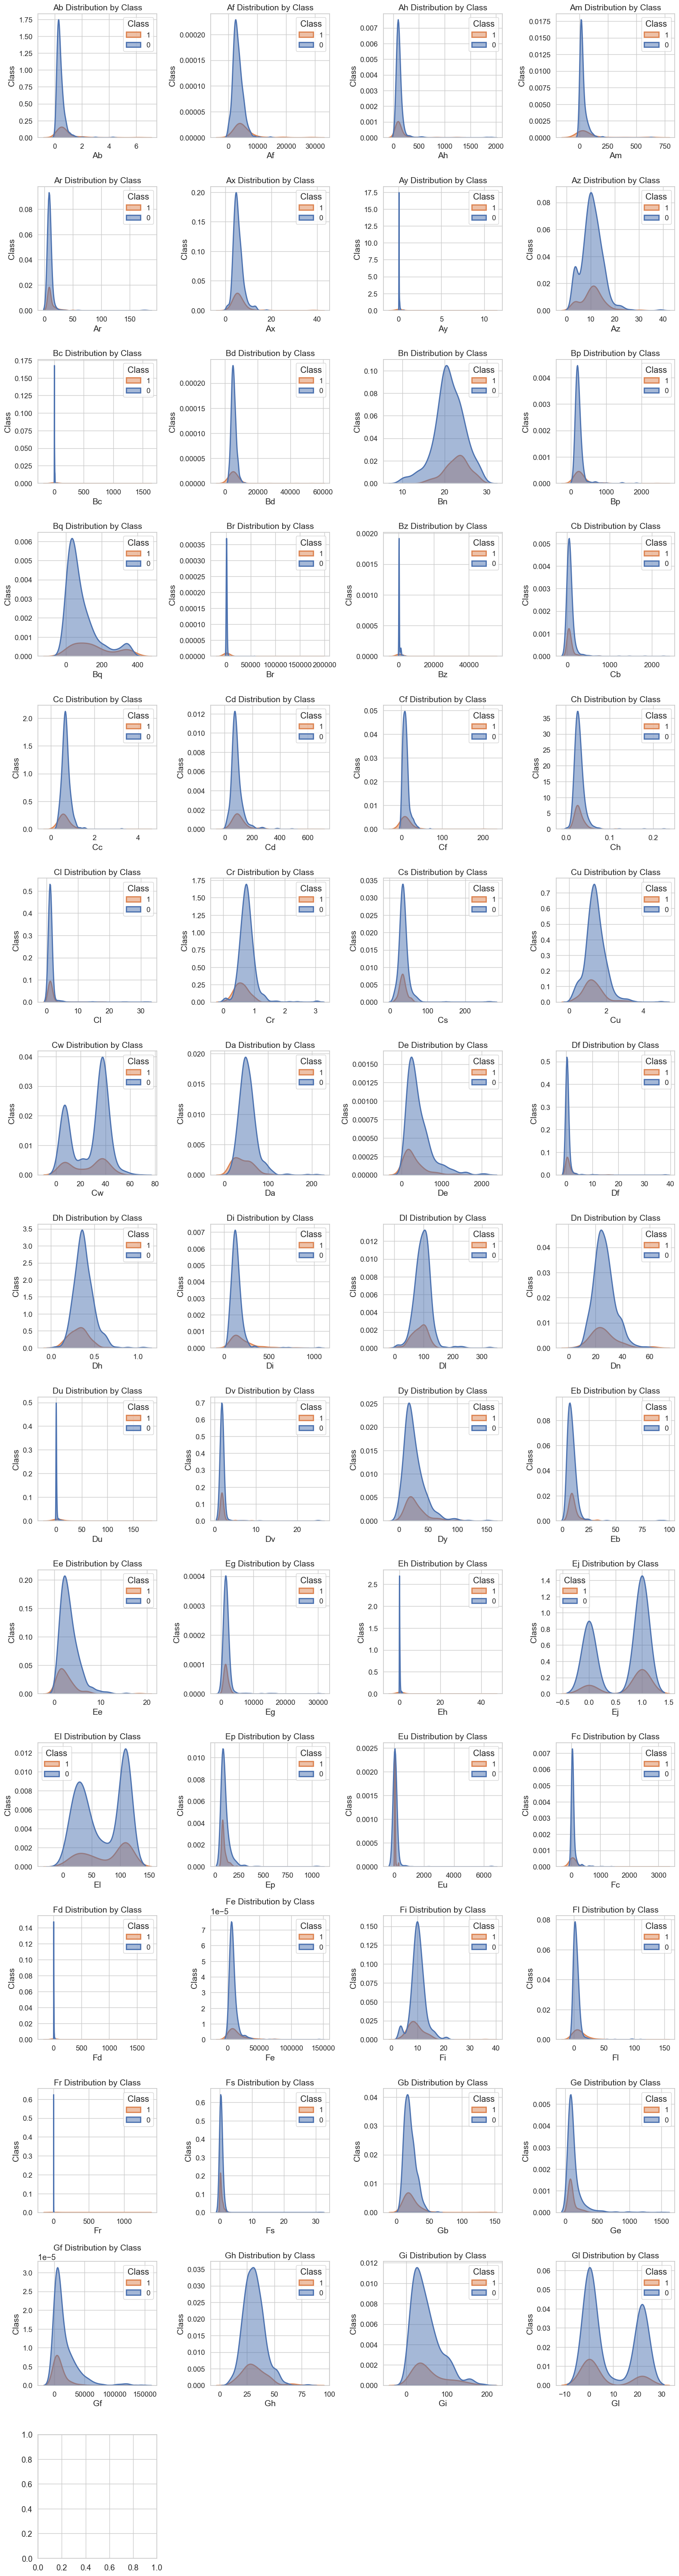

In [24]:
def plot_distribution(data):
    # 수치형 컬럼만 선택
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    num_cols = 4
    num_rows = len(numeric_cols) // num_cols + (1 if len(numeric_cols) % num_cols else 0)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4*num_rows))

    for i, col_name in enumerate(numeric_cols):
        # 목표 컬럼 제외한 나머지 컬럼 시각화
        if col_name != 'Class':
            # 플롯 위치 지정
            ax = axes[i // num_cols, i % num_cols]

            # kdeplot 플롯 그리기
            sns.kdeplot(data=data, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

            # 플롯 제목, 축 레이블, 범례 설정
            ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=14)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_col.title(), fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.legend([1, 0], title=target_col.title(), fontsize=12)

    # 빈 서브플롯 숨기기
    for j in range(len(numeric_cols), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_distribution(data)

In [32]:
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [37]:
# 목표 컬럼 분포 확인
def plot_target_feature(train, target_col, figsize=(16,5), palette='colorblind', name='Train'):
    
    # NaN 값 제거
    train = train[train[target_col].notna()]
    
    # 클래스 목록 및 색상 매핑
    classes = sorted(train[target_col].unique())
    colors = sns.color_palette(palette, len(classes))
    color_dict = dict(zip(classes, colors))

    # 클래스 순서대로 value_counts
    value_counts = train[target_col].value_counts().loc[classes]

    # 플롯 생성
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    ax = ax.flatten()

    # pie 차트 그리기
    ax[0].pie(
        value_counts, 
        shadow=True, 
        # 목표 컬럼 값 중 하나가 다른 값에 비해 더 크면 중앙에 표시
        explode=[0.05] * len(classes),
        # 퍼센트 표시
        autopct='%1.f%%',
        textprops={'size': 10, 'color': 'white'},
        colors=[color_dict[k] for k in classes]
    )

    # bar 차트 그리기
    sns.countplot(
        data=train, 
        y=target_col, 
        ax=ax[1], 
        order=classes,
        palette=color_dict
    )

    # 축 레이블 설정
    ax[1].yaxis.label.set_size(16)
    plt.yticks(fontsize=12)
    ax[1].set_xlabel('Count', fontsize=18)
    plt.xticks(fontsize=12)

    # 플롯 제목 설정
    fig.suptitle(f'{target_col} in {name} Dataset', fontsize=18, fontweight='bold')
    plt.tight_layout()

    plt.show()


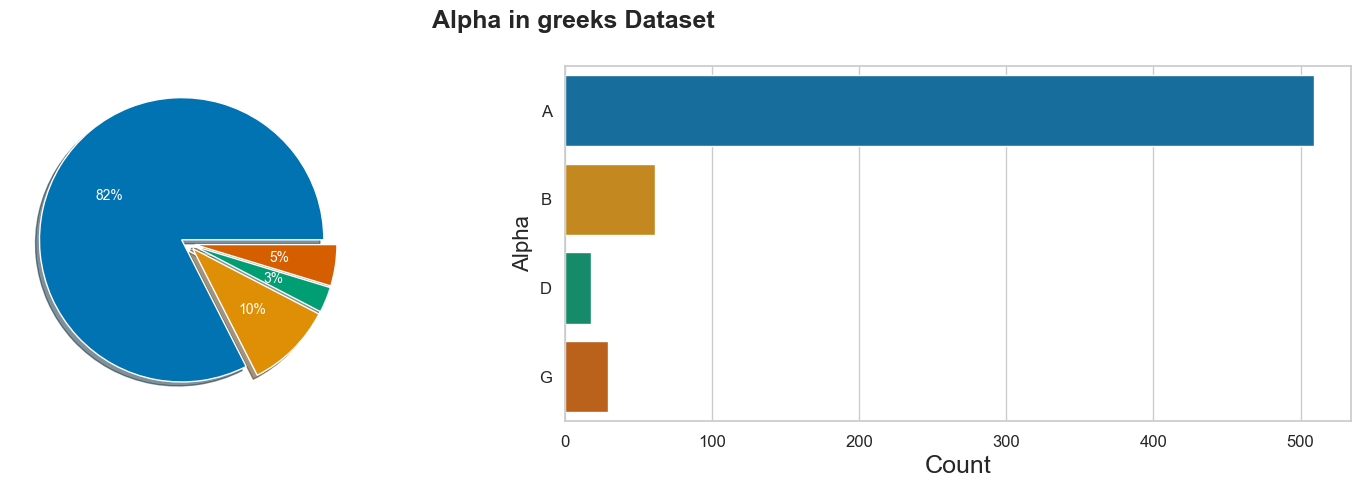

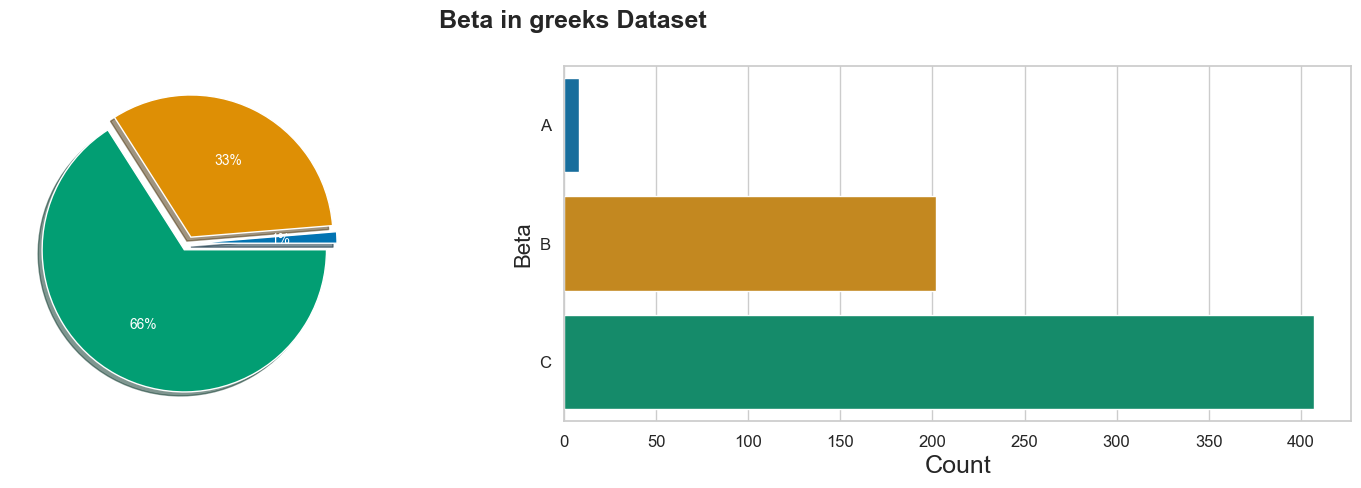

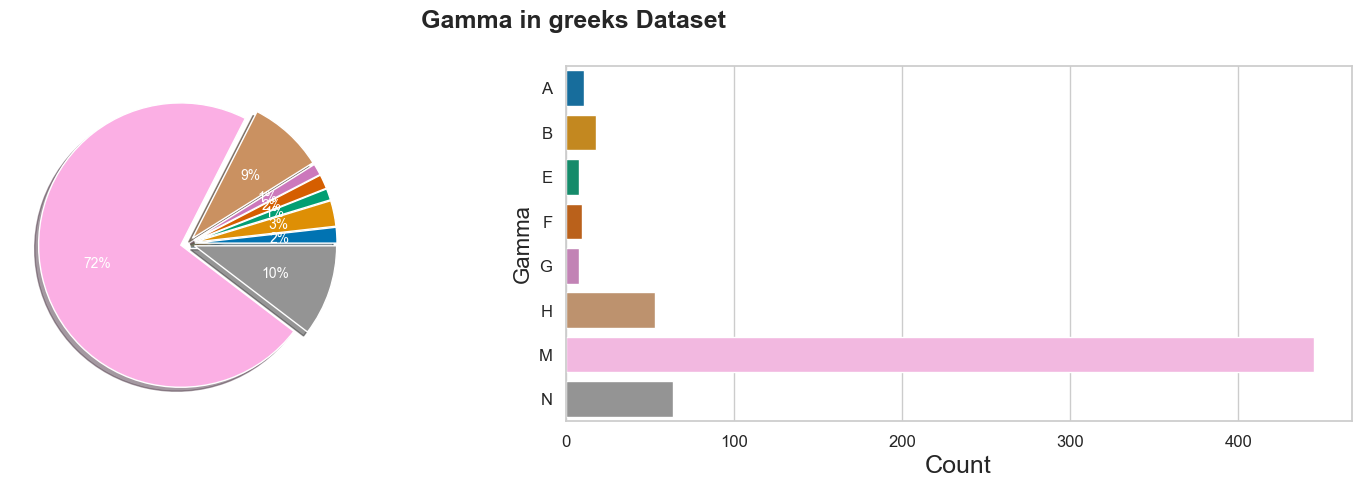

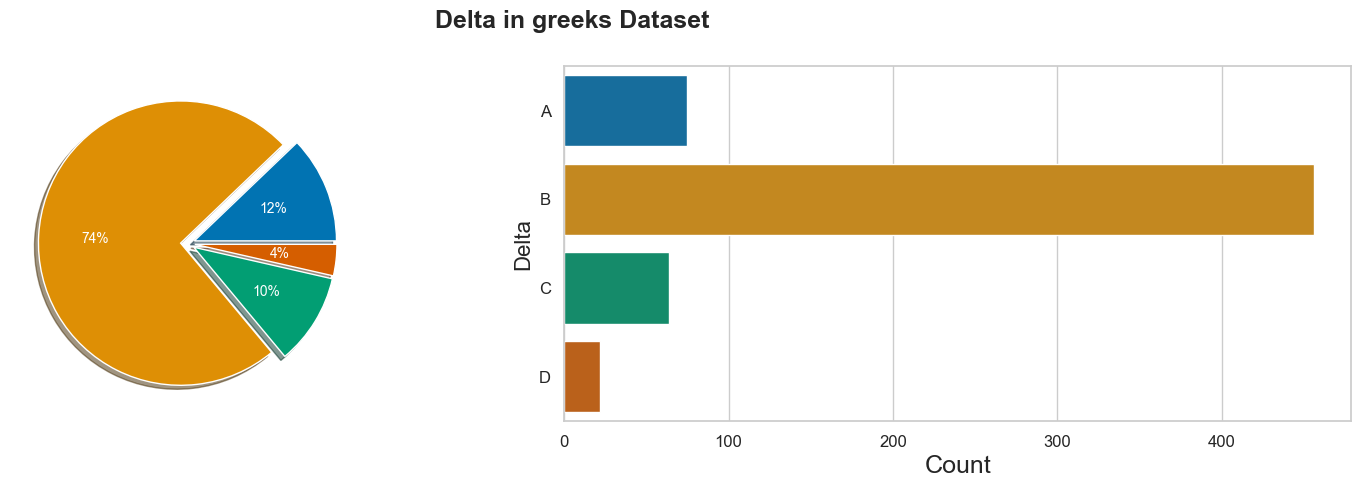

In [38]:
plot_target_feature(data, 'Alpha', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Beta', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Gamma', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Delta', figsize=(16,5), palette='colorblind', name='greeks')

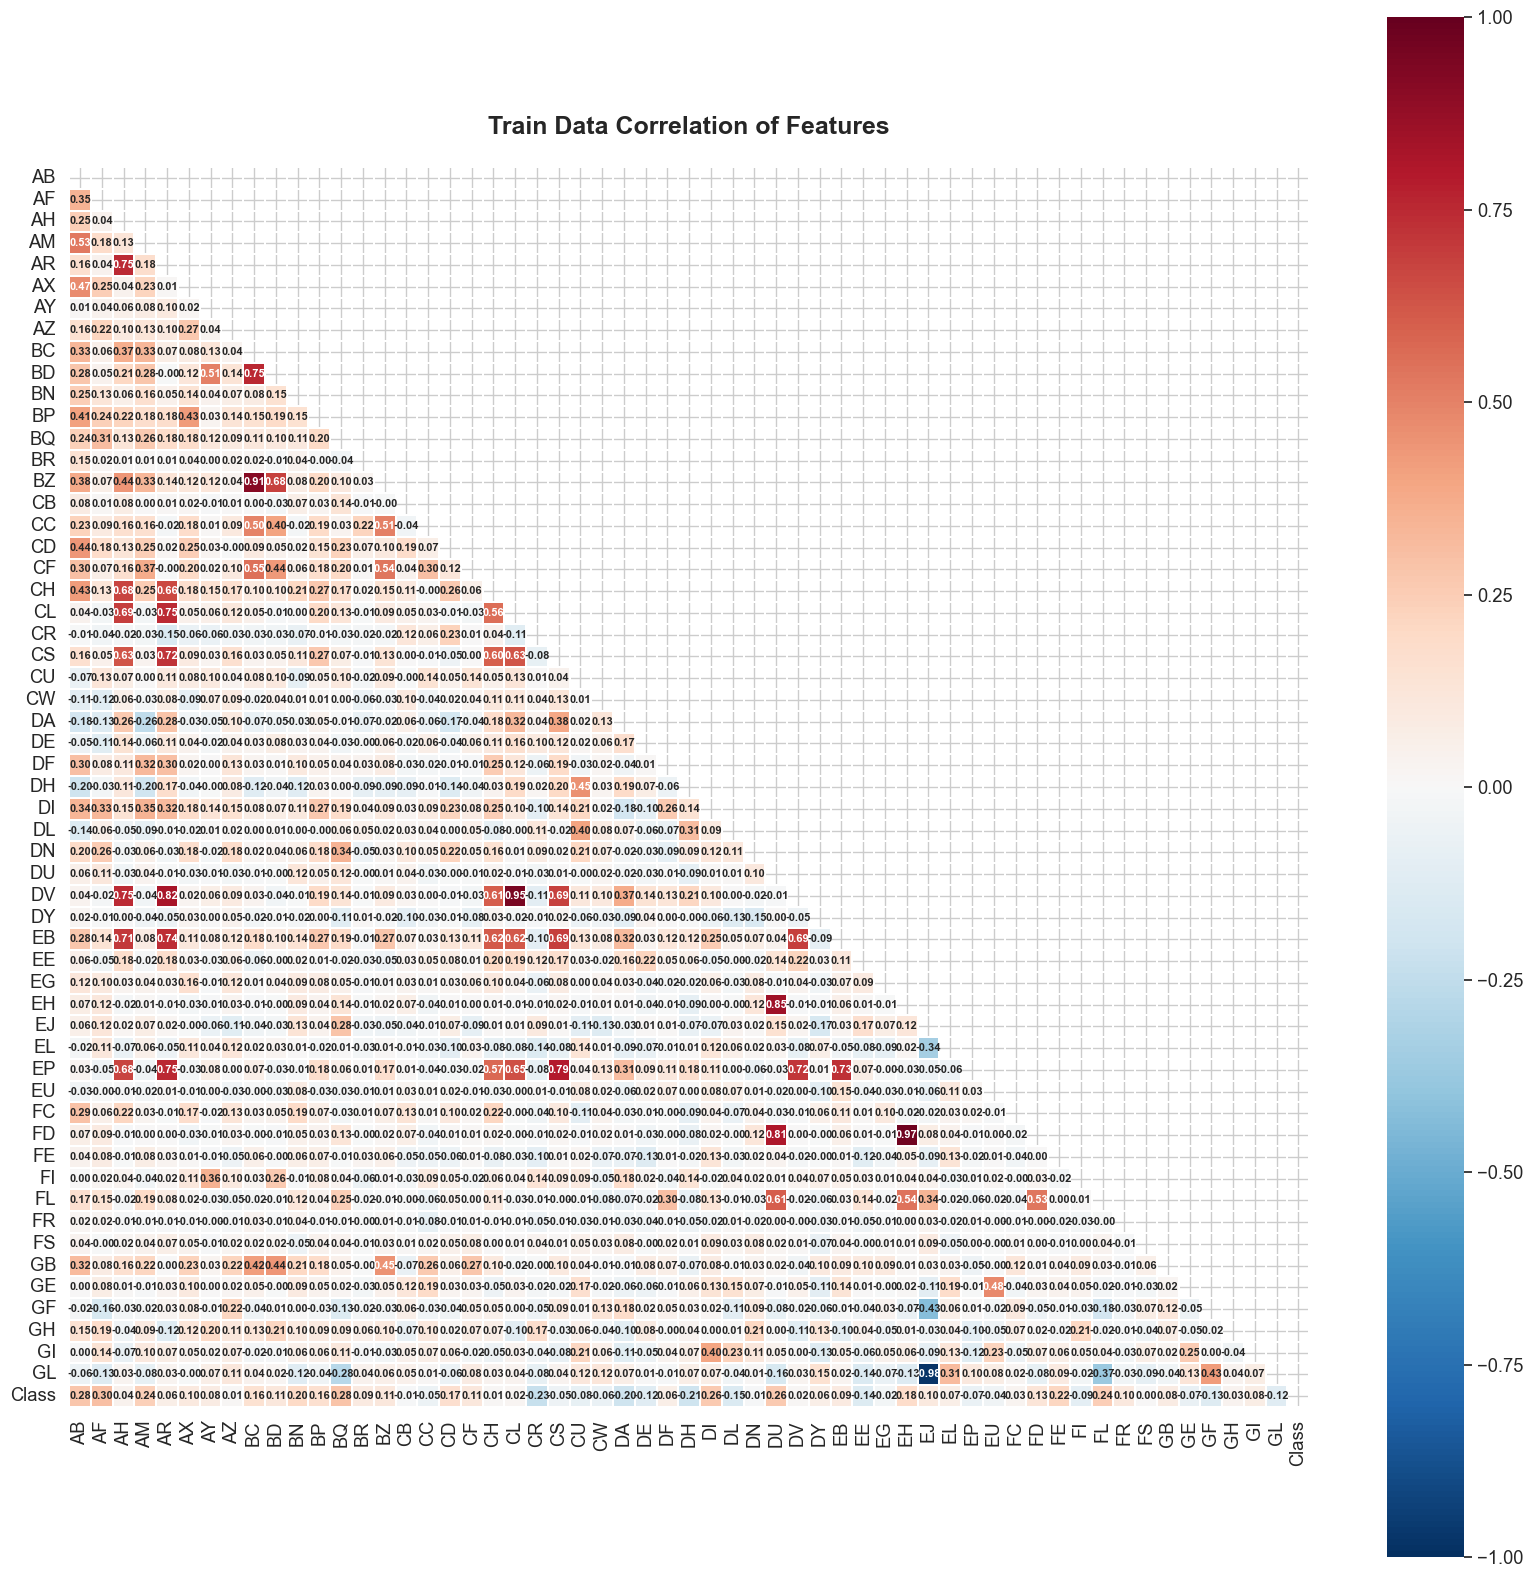

In [39]:
# 히트맵 그리기
def plot_heatmap(df, title):
    # 숫자형 컬럼만 추출
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    # 마스크 생성
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # 히트맵 설정
    plt.figure(figsize=(20, 20))
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=18)

    sns.heatmap(corr, mask=mask, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1,
                annot=True, fmt=".2f", annot_kws={"size": 8, "weight": "bold"},
                linewidths=0.1, linecolor='white', square=True)

    plt.show()

plot_heatmap(train, title='Train Data')

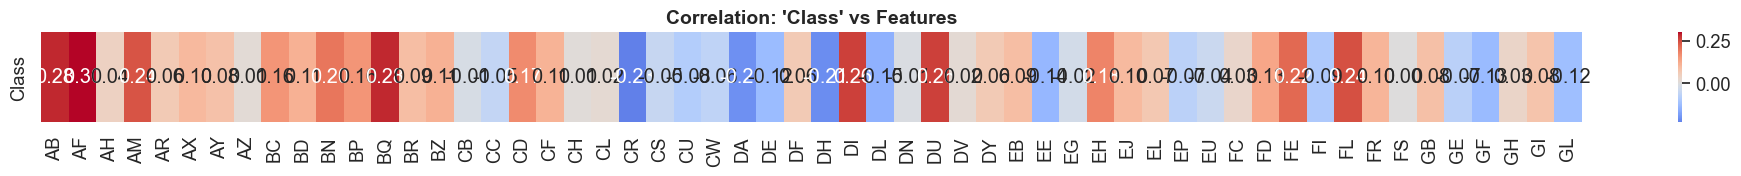

In [49]:
# 히트맵 중 목표 변수인 Class 행만 시각화
def plot_class_row_heatmap(df, target_col):
    # 숫자형만 선택
    numeric_df = df.select_dtypes(include=[np.number])

    # 상관계수 계산
    corr = numeric_df.corr()

    # 타겟과의 상관계수만 추출
    class_corr = corr.loc[[target_col]].drop(columns=[target_col])

    plt.figure(figsize=(min(1.5 * len(class_corr.columns), 20), 2))
    sns.heatmap(class_corr, annot=True, cmap='coolwarm', center=0, cbar=True, fmt=".2f")
    plt.title(f"Correlation: '{target_col}' vs Features", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_class_row_heatmap(train, target_col='Class')


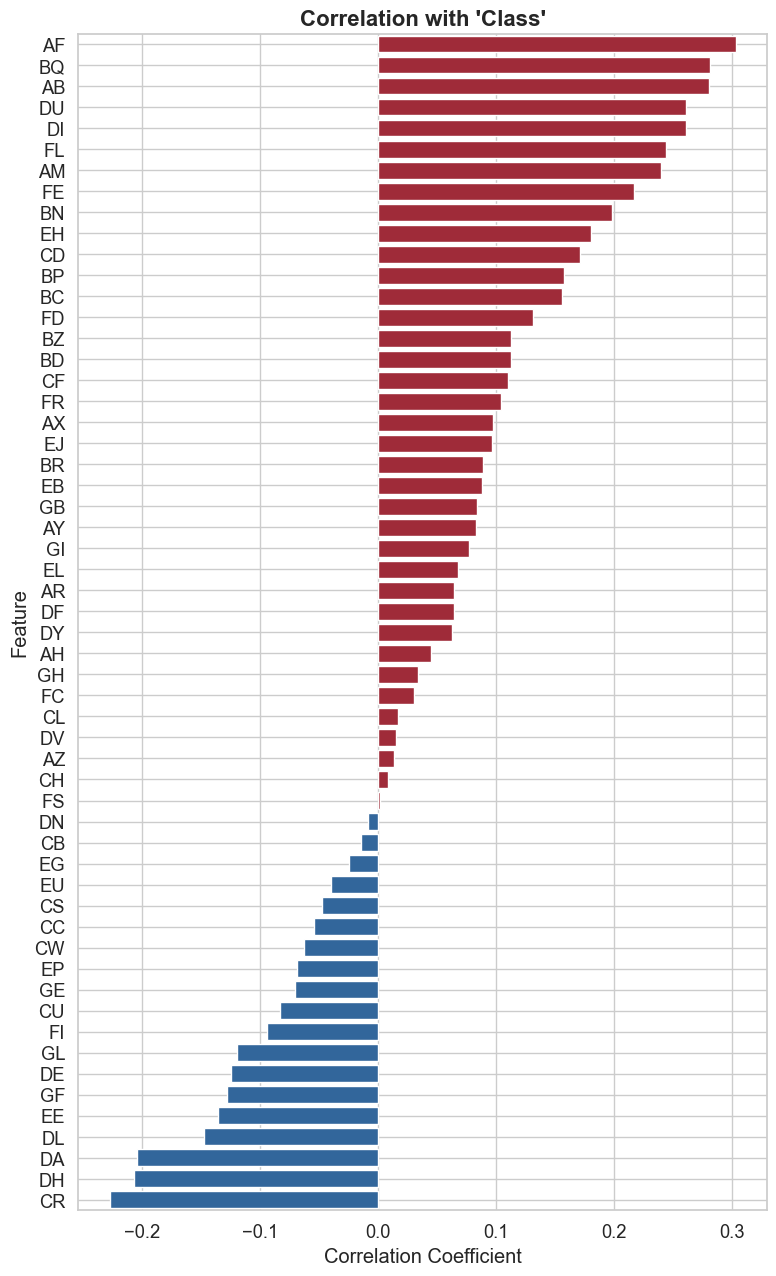

In [48]:
# 목표 변수와의 상관계수 막대그래프로 그리기
def plot_corr_with_target(df, target_col):
    # 숫자형 변수만 선택
    numeric_df = df.select_dtypes(include=[np.number])

    # 상관계수 계산
    corr = numeric_df.corr()

    # 타겟과의 상관계수만 추출 (자기 자신 제외)
    target_corr = corr[target_col].drop(target_col).sort_values(ascending=False)

    # 색상 반전: 양수는 파랑, 음수는 빨강
    colors = ['#b2182b' if val > 0 else '#2166ac' for val in target_corr.values]

    # 시각화
    plt.figure(figsize=(8, 13))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
    plt.title(f"Correlation with '{target_col}'", fontsize=16, fontweight='bold')
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_corr_with_target(train, target_col='Class')